In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 3.8 MB 36.1 MB/s 
     |████████████████████████████████| 503 kB 47.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=c29ee6d7b39c01a2214ca25dc9581671d8ad249e081c18a2009a4a09f29f1cd5
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
import io

Mounted at /content/gdrive


In [ ]:
#!unzip -u "/content/gdrive/My Drive/archive (3).zip" -d "/content/gdrive/My Drive/flickr8k_new"

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2846037553_1a1de50709.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2846843520_b0e6211478.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2847514745_9a35493023.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2847615962_c330bded6e.jpg  
  inflating: /content/gdrive/My Drive/flickr8k_new/Images/2847859796_4d9cb0d31f.jpg  
  i

In [ ]:
BASE_DIR = '/content/gdrive/My Drive/flickr8k_new'
WORKING_DIR = '/content/gdrive/My Drive/working'

In [ ]:
# load vgg16 model
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
# summarize
print(vgg_model.summary())

553476096/553467096 [==============================] - 9s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = vgg_model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8109 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
with open('features2.pkl', 'wb') as pickle_out:
     pickle.dump(features, pickle_out)
#pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features2.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
features='features2.pkl'

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
with open('all_captions.pkl', 'wb') as pickle_out:
     pickle.dump(all_captions, pickle_out)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'all_captions.pkl'), 'rb') as f:
    all_captions = pickle.load(f)

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8494

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

37

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(caption_model, show_shapes=True)

In [ ]:
# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    caption_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 74s 326ms/step - loss: 1.6761


In [ ]:
# save the model
caption_model.save(WORKING_DIR+'/best_model2.h5')


In [ ]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
from tensorflow import keras
caption_model = keras.models.load_model('/content/gdrive/MyDrive/working/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
from tensorflow.python import eager
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(caption_model, features[image_id], tokenizer, 37)
    print(features[image_id])
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
A man in a hat is displaying pictures next to a skier in a blue hat .
A man skis past another man displaying paintings in the snow .
A person wearing skis looking at framed pictures set up in the snow .
A skier looks at framed pictures in the snow next to trees .
Man on skis looking at artwork for sale in the snow
--------------------Predicted--------------------
startseq talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk talk


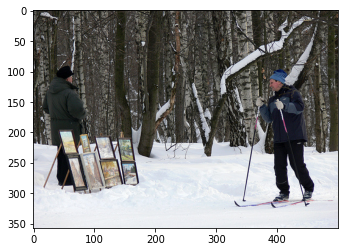

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [ ]:
def feature_gen_rand(image_path):
  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  feature = vgg_model.predict(image, verbose=0)
  return feature

In [ ]:
from PIL import Image
#max_length = 35
#tokenizer = Tokenizer()
import matplotlib.pyplot as plt
def generate_caption_rand(img_path):
    image = Image.open(img_path)
    features = feature_gen_rand(img_path)
    y_pred = predict_caption(caption_model, features, tokenizer, 35)
    print(features)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    return y_pred

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[0.         0.39231727 0.6230268  ... 0.2662117  0.         2.394261  ]]
--------------------Predicted--------------------
startseq young young climbs person and over beach on near in people on takes two on red in in in in in in in in in in in in in in in in in in in


'startseq young young climbs person and over beach on near in people on takes two on red in in in in in in in in in in in in in in in in in in in'

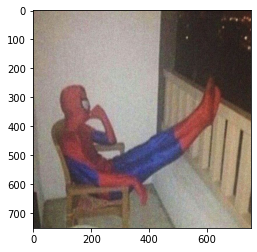

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test.jpg")

[[3.8608088 0.        5.75386   ... 0.        1.4879568 0.       ]]
--------------------Predicted--------------------
startseq man in darkened room playing in the snow endseq


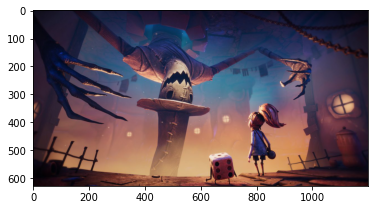

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test1.jpg")

[[0.        0.        0.        ... 0.        2.5572648 0.       ]]
--------------------Predicted--------------------
startseq black dog is walking on the grass with its legs in the air endseq


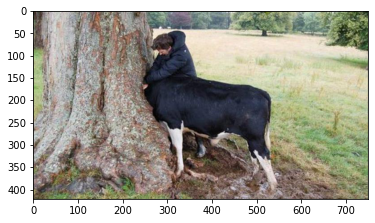

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test2.jpg")

[[0. 0. 0. ... 0. 0. 0.]]
--------------------Predicted--------------------
startseq two dogs are romping in the water endseq


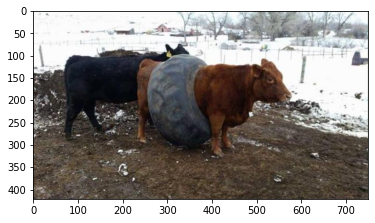

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test3.jpg")

[[0.        0.        0.        ... 0.        0.        2.7514384]]
--------------------Predicted--------------------
startseq man wearing spiderman scratches his head on his head endseq


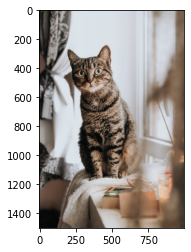

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test5.jpg")

[[0.        0.        0.        ... 0.        1.7383387 4.1590652]]
--------------------Predicted--------------------
startseq two girls are playing in the sand endseq


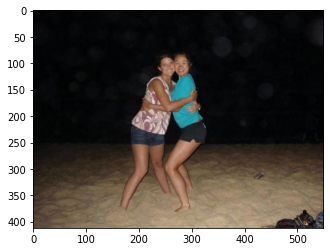

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test6.jpg")

[[0.        0.        4.0215244 ... 0.        0.        0.       ]]
--------------------Predicted--------------------
startseq woman in green jacket is firing gun endseq


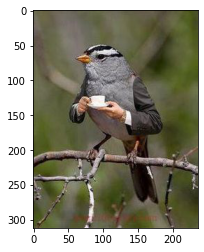

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test7.jpg")

[[0.         0.         0.72147727 ... 2.5081642  0.54663634 0.        ]]
--------------------Predicted--------------------
startseq rear view of red suv speeds through the rear endseq


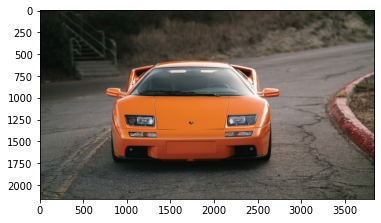

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test9.jpg")

[[2.70089   1.2163613 0.        ... 0.        0.        0.       ]]
--------------------Predicted--------------------
startseq woman wearing blue shirt is reading on the candles endseq


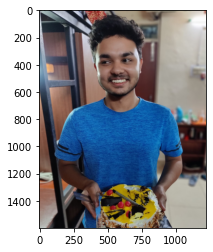

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/kinshuk.jpg")

[[0.         2.3805993  0.         ... 0.         0.23696725 0.        ]]
--------------------Predicted--------------------
startseq woman in green shirt and green jacket is walking down street endseq


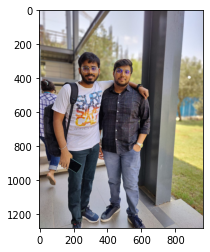

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/piyus.jpg")

[[0.        0.        0.        ... 0.        0.        1.4450645]]
--------------------Predicted--------------------
startseq woman in black shirt and nose blocking the suns colored lips endseq


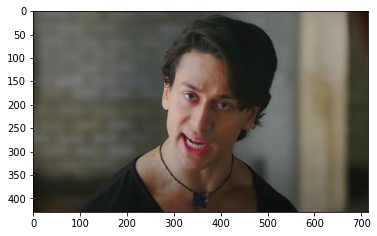

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/actor.jpg")

[[0.         0.         0.27845427 ... 0.         0.         0.        ]]
--------------------Predicted--------------------
startseq two women sit on bench endseq


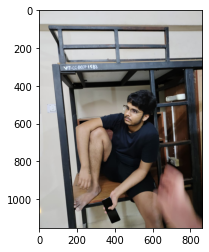

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/yashwant.jpeg")

In [ ]:
def remove_start_end(path):
  
  text = path
  b=text
  words = text.split()
  
  words2=[]

  data1="startseq"
  data2="endseq"
  status = False

  for word in words:
      if ((word == data1)or(word==data2)):
          words.remove(word)
          status = True
  for x in range(1,8):
    words2.append(words[x])


  if status:
      text = ' '.join(words2)
      a=text
      return a
  else:
      return b

[[0.        0.        0.2784564 ... 0.        0.        0.       ]]
--------------------Predicted--------------------
startseq empty empty girl holding is covered in stands these in in in in in in in in in in in in in in in in in in in in in in in in in in
empty girl holding is covered in stands


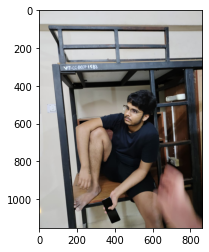

In [ ]:
s=remove_start_end("/content/gdrive/MyDrive/flickr8k_new/Images/yashwant.jpeg")
print(s)

In [ ]:
!pip3 install gpt-2-simple
#!pip install tensorflow==1.15
#%tensorflow_version 1.x
!pip install flask-ngrok
!pip install gpt-2-simple
!pip install language_tool_python

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
import os
from flask_ngrok import run_with_ngrok
from flask import Flask, request
import gpt_2_simple as gpt2_simple
import threading
import time
import tensorflow as tf
import requests 
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

In [ ]:
gpt2_simple.download_gpt2(model_name='124M')

Fetching checkpoint: 1.05Mit [00:00, 767Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 4.04Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 471Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:10, 47.0Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 340Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 6.69Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 6.65Mit/s]


In [ ]:
from google.colab import files
gpt2_simple.mount_gdrive()

Mounted at /content/drive


In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
gpt2_simple.copy_checkpoint_from_gdrive(run_name='run1')


In [ ]:
gpt2_simple.copy_checkpoint_from_gdrive(run_name='scifi_f')

In [ ]:
gpt2_simple.copy_checkpoint_from_gdrive(run_name='funny_train')

In [ ]:
sess = gpt2_simple.start_tf_sess()

gpt2_simple.load_gpt2(sess, run_name='run1')
def generate_scary(path):
  caption=generate_caption_rand(path)
  caption_A=remove_start_end(caption)

  gpt2_simple.generate(sess, run_name='run1',prefix=caption_A,length=250)

In [ ]:
#gpt2_simple.load_gpt2(sess, run_name='run1')
def generate_scary(path):
  #caption=generate_caption_rand(path)
  #caption_a=remove_start_end(caption)
  gpt2_simple.generate(sess, run_name='run1',prefix=path,length=250)

In [ ]:
gpt2_simple.load_gpt2(sess, run_name='scifi_f')
def generate_scifi(path):
  caption=generate_caption_rand(path)
  caption_a=remove_start_end(caption)
  gpt2_simple.generate(sess, run_name='scifi_f',prefix=caption_a,length=250)

Loading checkpoint checkpoint/scifi_f/model-1000
INFO:tensorflow:Restoring parameters from checkpoint/scifi_f/model-1000


Restoring parameters from checkpoint/scifi_f/model-1000


In [ ]:
gpt2_simple.load_gpt2(sess, run_name='funny_train')
def generate_humour(path):
  caption=generate_caption_rand(path)
  caption_a=remove_start_end(caption)
  gpt2_simple.generate(sess, run_name='funny_train',prefix=caption_a,length=250)

Loading checkpoint checkpoint/funny_train/model-1000
INFO:tensorflow:Restoring parameters from checkpoint/funny_train/model-1000


Restoring parameters from checkpoint/funny_train/model-1000


[[1.6873962  0.         0.         ... 0.         0.06063515 0.        ]]
--------------------Predicted--------------------
startseq woman in black shirt and pink shorts is sitting on bench outside endseq


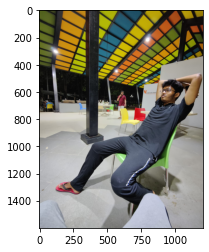

In [ ]:
generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/sathe.jpg")

In [ ]:
generate_scary("woman in black shirt and pink shorts is sitting on bench outside")

woman in black shirt and pink shorts is sitting on bench outside my door. 
She answers the door, and when the man in the 
shirt asks, “Are you DeFago?" 
he sips coffee. "I'm the person you want," 
he says. 


The man clicks the lock on the door. Then, 
the man comes in and starts walking. He looks like he is 
going for a ride in the morning. 


About ten o'clock the telephone rings again. Jenny 
knows who is living at the house. She approaches 
the front door and begins to watch the door. When 
she approaches the man, he apologizes, “ells blanche," and 
she hangs up. 


“Was it that guy again?" asks 
Jenny. 


“Yes," he says. "I'm going to call the operator 
and complain." 


The operator tells her to call back if it happens again. 





and she will try to trace the call. 


At eleven o'clock the telephone rings again. Jenny 
knows who is living at the house. She approaches the 


In [ ]:
generate_scifi("woman in black shirt and pink shorts is sitting on bench outside")

woman in black shirt and pink shorts is sitting on bench outside my apartment on the sidewalk. She's talking on the phone with a big smile. It's the most natural match I've ever seen in a web series. "It is," she said. I looked at Larkin. "How did you get those fancy chemistries? We're talking about a girl just like her. Guff ya! Ten or fifteen years back -- " He looked surprised. "Is it fine, Tessie? Is everything okay?" "I'm fine!" She shook her head. "It's just fine, Tessie. Listen, I got a hard time with Paul Cordell. He's my friend, everybody's happy about, nothing's wrong with him. But Tessie's friends thought he was a friend, and they accused him of trying to make them look bad. Of course he shook his head. They always do that and Tessie just stared at him and said, 'Tune in two hours ago.' " I went in and sat down. "How's the reception?" "It's sooo good, Tessie." "It'll be our twenty-second wedding day, what'cha got to eat?" "I got a surprise for you, kid. It's somethin him, I


In [ ]:
generate_humour("woman in black shirt and pink shorts is sitting on bench outside")

woman in black shirt and pink shorts is sitting on bench outside with a huge hand painted sign which said Radar Trap Ahead.
A little more investigative work led the officer to the boys accomplice: another boy about 100 yards beyond the radar trap with a sign reading TIPS and a bucket at his feet full of change.



After his return from Rome, Will couldnt find his luggage in the airport baggage area. He went to the lost luggage office and told the woman there that his bags hadnt shown up on the carousel.
She smiled and told him not to worry because they were trained professionals and he was in good hands.
Then she asked Will, Has your plane arrived yet?



A couple going on vacation but his wife was on a business trip so he went to the destination first and his wife would meet him the next day.
When he reached his hotel, he decided to send his wife a quick email.
Unfortunately, when typing her address, he mistyped a letter and his note was directed instead to an elderly preachers wife w

In [ ]:
generate_scary("two women sit on bench")

two women sit on bench 
and wait. 


When Bill doesn't come back, his widow is left 
to look after. And her daughter helps to house him out 
of the country. 


After the war, Bill got out of his car. He went 
for a swim. But when he came across a 
ten-foot-long sea 
pole. He looked at the boy, and he asked, "Shall we do it now?" 
"No," said the boy. "Let's wait till Martin comes." 


The old man jumped up, jumped out the window and 
started running. "When Martin comes, you tell him I 
couldn't wait," he called. 








A businessman arrived at a hotel late one night and asked 
for a room. The room clerk told him the hotel was all 
filled up. "There is only one empty room," he said. "But 
we don't rent that one because it is haunted." 


"I'll take it," said the businessman. "I don't believe 
in ghosts." 


The man went up to the room. He


In [ ]:
generate_scifi("two women sit on bench")

two women sit on bench in the library, while a third sit in a nearby room. The library is small and empty; it seems to hang slowly become slowly. Kirk stares at the empty bench and tries to shove it into the path of the two more women. Finally: "Could you arouse my curiosity by bringing a tub of plain coffee to the table?" Both women turn and leave the room. The men leave the room, too stunned to speak. Kirk turns to Mara who is studying the dais with thoughtful eyes. "Ah yes, cross-legged. T -- that wouldn't do it. You could even bring a child to the table." Asir takes a deep breath and turns to look at the Professor. "I am afraid you're not qualified to make a judgement on the sanity of these children." a Okay creature , Asir thought. He should make no effort to prove anything, however limited. "Go on." Karine said. "Go to hell." He stepped out into a circle of a great circle, then disappeared. The creature who sat beside him still remained.  Karine stepped back to observe the bleedi

In [ ]:
generate_humour("two women sit on bench")

tow women sit on bench and teach her husband to sit down next to the farmer.
"Well," the farmer said, "today I was sitting by my cow, milking her. Just as I got the bucket full, she lifted her left leg and kicked over the bucket."
"Okay," said the man, "but that's not so bad." "Some things you just can't explain," the farmer replied. "So what happened then?" the man asked. The farmer said, "I took her left leg and tied it to the post on the left."
"And then?"
"Well, I sat back down and continued to milk her. Just as I got the bucket full, she took her right leg and kicked over the bucket."
The man laughed and said, "Again?" The farmer replied, "Some things you just can't explain." "So, what did you do then?" the man asked.
"I took her right leg this time and tied it to the post on the right."
"And then?"
"Well, I sat back down and began milking her again. Just as I got the bucket full, the stupid cow knocked over the bucket with her tail."
"Hmmm," the man


In [ ]:
generate_scary("two girls are playing in the sand")

two girls are playing in the sand when they 
find them. They eat popcorn, melt down ice, and go 
for it. 


The old woman's name is 
Daisy. She lives on a farm about eight miles away 
and is famous for her dancing. She and her husband live 
in a house on a farm about eight miles away 
and the road leads back their way. 


The boy runs up on the farm and beats his dog 
to make it quiet. "That's a nice dog," he says. "I'll 
put it in the soup, and we'll have it for supper." 


That night the boy plays the piano. "What do you come for?" 
he asks. "To play chess and go to the movies." 


To make it more cheerful, the boy adds a little 
dingo: 


"A big mean dog," says the wife. "I'll 
put it in the soup, and we'll have it for supper." 


That night the boy plays the piano. "What do you come for?" 
he asks. "To play chess and go to the movies." 




In [ ]:
generate_scifi("two girls are playing in the sand")

two girls are playing in sand this sand." "Why sand?" Larkin demanded. "A sand-girl beach trip always ends in disaster. Nobody likes being swamped." "But not here." "Why? Why? Why -- " Tee jay said nothing more about it. Then she turned to Steve. "If this is as serious as bragging, then we can hardly blame him. After all, he was a boy again. And now he's a boy again!" The lights blinked out, and the darkness was gone. The only sound was the restless cursing of the ledgers, and the grinding of door bodies. Steve ran for his life, to his knees. He ran again, and found himself walking aimlessly. Overhead he could hear the grinding of an air-foil, and the crashing of the suddenly come alive landing. Long slavering feet he failed to control. A scream came, then a fat thump, and a metallic thump, and another. He could see the retreating frontiers of the world from a thousand miles away, no longer pursu'd by the great Monsters, but by some random imposter who had some magic formation which he

In [ ]:
generate_humour("two girls are playing in the sand")

two girls are playing in sand dunes. A man came in and asked the farmer, "Hey, why are you sitting here on this beautiful day, getting drunk?" The farmer shook his head and replied, "Some things you just can't explain."
"So what happened that's so horrible?" the man asked as he sat down next to the farmer.
"Well," the farmer said, "today I was sitting by my cow, milking her. Just as I got the bucket full, she lifted her left leg and kicked over the bucket."
"Okay," said the man, "but that's not so bad." "Some things you just can't explain," the farmer replied. "So what happened then?" the man asked. The farmer said, "I took her left leg and tied it to the post on the left."
"And then?"
"Well, I sat back down and continued to milk her. Just as I got the bucket full, she took her right leg and kicked over the bucket."
The man laughed and said, "Again?" The farmer replied, "Some things you just can't explain." "So, what did you do then?" the man asked.
"I took her right leg this time and


In [ ]:
generate_scary("man in darkened room playing in the snow")

man in darkened room playing in the snow. 


But when the sound of a crash came to a close, and the 
man was dead, the driver of the truck looked up. 
The driver of the truck looked up at him. When Black- 
well saw his queer, hideous face, he shuddered. The 
driver called to him, “There is room for one more." Then 
he waited for a minute or two, and he drove off. 


In the morning Blackwell told his friends what had 
happened. “You were dreaming," they said. 


"I must have been," he said, “but it didn't seem like 
a dream." 


After breakfast he went into Philadelphia. He spent 
the day high above the city in one of the new office 
buildings there. 


Late in the afternoon he was waiting for an elevator 
to take him back down to the street. But when it arrived, 
it was very crowded. One of the passengers looked out 
and called to him. “There is room for one more," he 
said. It was the driver of the hearse
